# Fully connected networks

In this exercise you are to write computer programs implementing perceptrons with LLL fully connected layers. The perceptrons differ in their layouts: in the number L of layers, and in the number of neurons in the hidden layers $\ell=1,\ldots,L-1$:

Network 1: No hidden layers (L=1)

Network 2: One hidden layer with 10 neurons

Network 3: One hidden layer with 50 neurons

Network 4: Two hidden layers with 50 neurons each

The networks are to be trained on CIFAR-10 data, and therefore they should have 3072 input units and 10 output units. Additional properties of the networks, and the training you should perform is specified in the following list. For definitions of the quantities discussed, read chapter 6 of the lecture notes.

$\bullet$ Before you start training your networks, center the input data around zero. For each data set, subtract the mean input of the training set from all inputs: $\underline{X}^{(\mu)} = \underline{x}^{(\mu)} - \left \langle \underline{x} \right \rangle_\text{train}$. Here $\underline{x}^{(\mu)}$ is an input pattern before centering and $\left \langle \underline{x} \right \rangle_\text{train} = \frac{1}{p}\sum_{\nu=1}^p \underline{x}^{(\nu)}$, where the summation is over all ppp patterns in the training set. Note: to shift the data in the validation and test sets, you use the mean input of the training set.

$\bullet$ Use the energy function $H = \frac{1}{2} \sum_{\mu,i} (t_i^{(\mu)}-O_i^{(\mu)})^2$. Train the network using stochastic gradient descent with mini-batch size $m_B = 100$.

$\bullet$ Train the network for 20 epochs. Shuffle the training set into a random permutation at the start of each epoch.

$\bullet$ Use a learning rate of $\eta = 0.1$. For each mini-batch, the increment of a weight $w_{mn}^{(\ell)}$ in layer $\ell$ is given by $\delta w_{mn}^{(\ell)} = \eta \sum_{\mu=1}^{m_B}\delta_m^{(\ell,\mu)}V_n^{(\ell-1,\mu)}$, where the summation is over the patterns in the mini-batch. Here, $\delta_m^{(\ell,\mu)}$ denotes the error of the $m^\text{th}$ neuron in the $\ell^\text{th}$ layer evaluated for the $\mu^\text{th}$ pattern in the mini-batch. The state of the $n^\text{th}$ neuron in the $(\ell-1)^\text{th}$ layer evaluated for pattern $\mu$ is denoted by $V_n^{(\ell-1,\mu)}$.

$\bullet$ Use neither regularization nor momentum.

$\bullet$ Use sigmoid activation functions $\sigma(b) = [1+\exp(-b)]^{-1}$ for layers $\ell=1,\ldots$.

$\bullet$ Initialize the weights feeding into a given neuron from a Gaussian distribution with zero mean and standard deviation equal to one over the square root of the number of weights feeding into this neuron. Initialize all thresholds to zero.

$\bullet$ Train using the training set to compute gradients. While training keep track of the classification errors for training and validation set. Record these two classification errors as well as the weights and thresholds at the start of every epoch. After 20 epochs, take the weights and thresholds that give the smallest classfication error for the validation set as your training result.

$\bullet$ After training, test your results by classifying the images in the test set using the weights and thresholds obtained above: Compute the classification error for the test set. 

Intialize all the functions

In [1]:
import numpy as np
from numpy import random as rnd
import csv
import matplotlib.pyplot as plt

def unpickle(file):
    "Returns an a dictionary of a single batch, if filename is correct"
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def calculate_mean(x_train):
    "Calculate the mean of a set of training data"
    mean = np.mean(x_train,axis=0)
    return mean


def center_data(x_train):
    
    mean = calculate_mean(x_train)
    centered_data = x_train - mean
    centered_data /= 255
    return centered_data

def sigmoid_activation_function(b):

    
    return np.power((1+np.exp(-b)), -1)


def shuffle(X, y):
    '''
    Shuffle two corresponding arrays
    '''
    assert len(X) == len(y)
    random = np.arange(len(X))
    np.random.shuffle(random)
    X = X[random]
    y = y[random]
    return X, y


def g(b):
    
    return sigmoid_activation_function(b)

def dg(b):
    
    o_b = sigmoid_activation_function(b)
    return o_b*(1-o_b)

def create_layer(inputsize, layersize):
    
    neurons = np.zeros((layersize,1))
    neurons = neurons.reshape(layersize,1)
    w_ij = rnd.normal(size=(layersize, inputsize),scale= (1/(np.sqrt(inputsize))))
    return (neurons, w_ij)

def esign(i):
    if i == 0:
        return 1
    return np.sign(i)

def calculate_output(threshold, weight_matrix, x):
    
    if weight_matrix.shape[1]==1:
        weight_matrix = weight_matrix.T
    inner_sum = weight_matrix@x
    inner_sum = inner_sum - threshold
    ret = g(inner_sum)
    assert(ret.shape == threshold.shape)
    return ret

def calculate_output_batch(threshold, weight_matrix, V, batchsize):
    
    
    inner_sum = weight_matrix@V
    inner_sum = inner_sum.reshape((threshold.shape[0],batchsize))
    inner_sum = inner_sum - threshold
    ret = g(inner_sum)
    assert(ret.shape == (threshold.shape[0],batchsize))
    return ret



def propagate_forward(V : list, O : list, w : list, batchsize : int) -> None:

    assert(len(V)-1==len(O) and len(O)==len(w))

    for l in range(1,len(V)):
        V[l]= calculate_output_batch(O[l-1],w[l-1],V[l-1], batchsize)


def calculate_b(w, x, O):
    inner_sum = np.dot(w,x)
    inner_sum = inner_sum - O
    return inner_sum

def calculate_d_L(b, t, V):
    
    return dg(b)(t-V)

def calculate_single_d(d_l, w, b):
    
    dgb = dg(b)
    inner_product = (d_l.T@w).T
    ret = np.multiply(inner_product,dgb)
    return ret


def calculate_all_d(V, O, w, t):
    
    L = len(O)-1
    b_L = calculate_b(w[L],V[L], O[L])
    b_L = dg(b_L)
    temp = (t-V[-1])
    delta_start = b_L*temp
    d = [[]]*(L+1)
    d[L] = delta_start
    for i in range(L, 0, -1):
        if(w[i].shape[1]==1):
            w[i] = w[i].T

        b =  calculate_b(w[i-1],V[i-1],O[i-1])
        delta = calculate_single_d(d[i],w[i],b)
        d[i-1] = delta
    return d



def propagate_backwards(V : list, O : list, w : list, t : int, learning_rate: float, batchsize : int):

    L = len(w)
    d = calculate_all_d(V,O,w,t) 
    for l in range(L):
        if(w[l].shape[1]==1):
            d_w = learning_rate*(d[l]@V[l])
        else:
            d_w = learning_rate*(d[l]@V[l].T)
        d_O = learning_rate* (d[l]@np.ones((batchsize,1)))
        w[l] +=  d_w
        O[l] -= d_O


def create_multible_layers(*argv):
    
    w = []
    V = []
    O = []
    inputlayer = np.zeros((argv[0],1))
    V.append(inputlayer)
    old_layersize = argv[0]
    for layersize in argv[1:]:
        O_i = np.zeros((layersize,1))
        V_i, w_i = create_layer(old_layersize,layersize)
        old_layersize = layersize    
        w.append(w_i)
        V.append(V_i)
        O.append(O_i)
    return (w,V,O)


def learn(learning_rate:float, data: list, labels: list,test_data : list, test_labels : list, batchsize: int, *argv):

    w,V,O = create_multible_layers(*argv)
    return_w = []
    return_c = []
    return_O = []
    for T in range(20):
        #Permutate the data in the beginning of each epoch
        data,labels = shuffle(data,labels)
        for i in range(0, len(data), batchsize):
            my = i
            bs = batchsize
            if my + batchsize >= len(data):
                bs =  len(data) - my
            V[0] = np.array(data[my:my+bs]).T
            t = np.array(labels[my:my+bs]).T            
            propagate_forward(V,O,w, bs)
            propagate_backwards(V,O,w,t,learning_rate, bs)
        C = calculate_classification_error(V,w,O,test_data, test_labels)
        return_c.append(C)
        return_w.append(w)
        return_O.append(O)
    print("Finished learning!")
    return return_c, return_w, V, return_O
        

def calculate_classification_error(V,w,O, test_data, test_labels):
    
    inner_sum = 0
    pval = len(test_data)
    for my in range(pval):
        V[0] = np.array(test_data[my])
        t_my = test_labels[my]
        propagate_forward(V,O,w,1)
        y_i = np.argmax(V[-1],axis=0)
        y = np.zeros((len(V[-1]),1))
        y[y_i] = 1
        inner_sum += np.sum(np.abs(y-t_my))
    return inner_sum/(2*pval)



def transformlabels(labels, n):
    
    for i,label in enumerate(labels):
        temp = np.zeros((n,1))
        temp[label] = 1
        labels[i] = temp



Load the data

In [ ]:

folder_name = "../data/cifar-10-batches-py/"
batch_1 = unpickle(folder_name+"data_batch_1")
batch_2 = unpickle(folder_name+"data_batch_2")
batch_3 = unpickle(folder_name+"data_batch_3")
batch_4 = unpickle(folder_name+"data_batch_4")
batch_5 = unpickle(folder_name+"data_batch_5")

data = batch_1[b'data']
data = np.append(data,batch_2[b'data'], axis=0)
data = np.append(data,batch_3[b'data'], axis=0)
data = np.append(data,batch_4[b'data'], axis=0)
#data = np.append(data,batch_5[b'data'], axis=0)
labels = batch_1[b'labels']
#Since labels are only a normal array
labels += batch_2[b'labels']
labels += batch_3[b'labels']
labels += batch_4[b'labels']
#labels += batch_5[b'labels']
data = center_data(data)
transformlabels(labels,10)
labels = np.array(labels)
labels = labels.astype(np.uint8)
labels = np.array(labels).reshape(40000,10)
test_batch = unpickle(folder_name+"test_batch")
test_data = batch_5[b'data']
test_labels = batch_5[b'labels']
test_data = center_data(test_data)
transformlabels(test_labels,10)
test_labels = np.array(test_labels)

test_labels = test_labels.astype(np.uint8)


minibatch_size = 100
learning_rate = 0.1


Network 1

Finished learning!


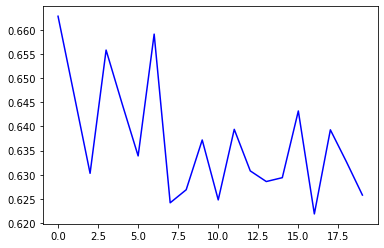

In [2]:
c1,w1, V1,O1 = learn(learning_rate,data,labels,test_data, test_labels, minibatch_size, 3072,10)
plt.plot(c1, color="blue",label="Network 1")



Network 2

Finished learning!


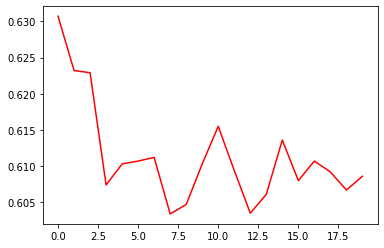

In [3]:
c2,w2,V2,O2 = learn(learning_rate,data,labels,test_data, test_labels, minibatch_size, 3072,10,10)
plt.plot(c2, color = "red", label = "Network 2")


Network 3

Finished learning!


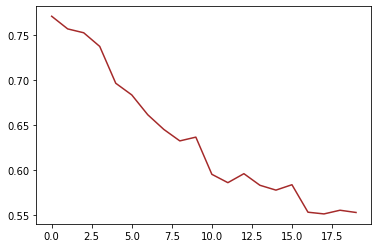

In [4]:
c3,w3,V3,O3 = learn(learning_rate,data,labels,test_data, test_labels, minibatch_size, 3072,50,10)
plt.plot(c3, color = "brown", label = "Network 3")


Network 4

Finished learning!


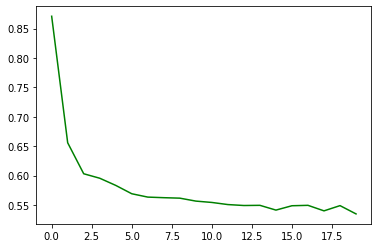

In [5]:
c4,w4,V4,O4 = learn(learning_rate,data,labels,test_data, test_labels, minibatch_size, 3072,50,50,10)
plt.plot(c4, color = "green", label = "Network 4")


Let's compare the graphs

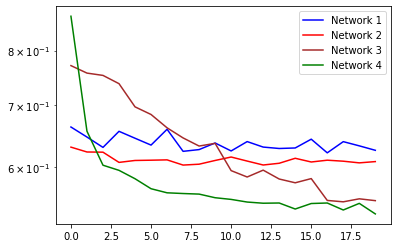

In [6]:
plt.yscale("log")
plt.plot(c1, color="blue",label="Network 1")
plt.plot(c2, color = "red", label = "Network 2")
plt.plot(c3, color = "brown", label = "Network 3")
plt.plot(c4, color = "green", label = "Network 4")
plt.legend()
plt.show()


Let's compare the Classification errors

In [12]:
def calculate_table_entries(C,w,V,O, showcase_data, showcase_labels):
    max_i = np.argmin(C,axis=0)
    classif_error_test = calculate_classification_error(V,w[max_i],O[max_i],showcase_data, showcase_labels)
    classif_error_train = calculate_classification_error(V,w[max_i],O[max_i],data, labels)
    return [max_i, C[max_i], classif_error_test,classif_error_train]
    
    
batch_showcase = batch_1 = unpickle(folder_name+"test_batch")
showcase_data = batch_showcase[b'data']
showcase_labels = batch_showcase[b'labels']
showcase_data = center_data(showcase_data)
transformlabels(showcase_labels,10)

from tabulate import tabulate
column1 = [1] + calculate_table_entries(c1,w1,V1,O1,showcase_data, showcase_labels)
column2 = [2] + calculate_table_entries(c2,w2,V2,O2,showcase_data, showcase_labels)
column3 = [3] + calculate_table_entries(c3,w3,V3,O3,showcase_data, showcase_labels)
column4 = [4] + calculate_table_entries(c4,w4,V4,O4,showcase_data, showcase_labels)
columnlabels = ["Network","best epoch", "C validation set", "C test set", "C training set"]
rowlabels = ["network 1", "network 2", "network 3", "network 4"]
print(tabulate([column1, column2, column3,column4], headers=columnlabels))

  Network    best epoch    C validation set    C test set    C training set
---------  ------------  ------------------  ------------  ----------------
        1            16              0.6219        0.6304                 9
        2             7              0.6034        0.6048                 9
        3            17              0.5511        0.5559                 9
        4            19              0.5349        0.5356                 9


# Discussion

It is clear that the addition of a second layer improves the learning performance significant, while adding neurons to a layer did not show a big boost in performance for the case of a hidden layer size of 1 and 2.
The classification error of the test set is slightly less than of the validation set, pointing to the possibility of overfitting.
The data shows, that added complexity does not necessarily result in improved performance. Furthermore it shows that it is easy to overfit a network and one should be vary when analyzing their results.